## Activity Recognition
### 0) Load data 
### 1) Data Overview and preprocess
* 1-1) General
* 1-2) Data missing issue and data cleaning 
* 1-3) Sequence

### 2) Feature extract 
* Time Domain
  * 2-1) mean / median / max / min / variance / 
* Frequence Domain
  * 2-2) energy / skew 
* 2-3) PCA
* 2-4) sqrt(x^2 + y^2 + z^2)

### 3) Model
* 3-0) train-test split 
* 3-1) SVM
* 3-2) Decision Tree
* 3-3) NN

### 4) Observation


In [134]:
# OP 
import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


# ML 
from sklearn import metrics



Populating the interactive namespace from numpy and matplotlib


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# set plot style
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

## 0) Load data and preprocess

In [3]:
# load the data 

df=pd.read_csv('imu_activity_recognition.csv')


## 1) Data overview

### 1-1) General

In [4]:
len(df)

1158399

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1158399 entries, 0 to 1158398
Data columns (total 31 columns):
timestamp                1158399 non-null float64
activity_id              1158399 non-null object
heart_rate               105839 non-null float64
wrist_accelerometer_x    1150386 non-null float64
wrist_accelerometer_y    1150386 non-null float64
wrist_accelerometer_z    1150386 non-null float64
wrist_gyroscope_x        1150386 non-null float64
wrist_gyroscope_y        1150386 non-null float64
wrist_gyroscope_z        1150386 non-null float64
wrist_magnetometer_x     1150386 non-null float64
wrist_magnetometer_y     1150386 non-null float64
wrist_magnetometer_z     1150386 non-null float64
chest_accelerometer_x    1157210 non-null float64
chest_accelerometer_y    1157210 non-null float64
chest_accelerometer_z    1157210 non-null float64
chest_gyroscope_x        1157210 non-null float64
chest_gyroscope_y        1157210 non-null float64
chest_gyroscope_z        1157210 non-nu

In [6]:
# take a look on null data 
df[df.wrist_accelerometer_x.isnull()].head(5)

,timestamp,activity_id,heart_rate,wrist_accelerometer_x,wrist_accelerometer_y,wrist_accelerometer_z,wrist_gyroscope_x,wrist_gyroscope_y,wrist_gyroscope_z,wrist_magnetometer_x,...,ankle_accelerometer_x,ankle_accelerometer_y,ankle_accelerometer_z,ankle_gyroscope_x,ankle_gyroscope_y,ankle_gyroscope_z,ankle_magnetometer_x,ankle_magnetometer_y,ankle_magnetometer_z,user_id
16265,200.31,lying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.583433,-1.327890,-10.07380,0.230396,-0.030559,0.038560,-23.6012,35.75320,24.1635,a
16266,200.32,lying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.253883,-0.985644,-9.88639,0.281307,-0.010447,0.038095,-23.5053,36.20730,22.9298,a
16267,200.33,lying,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.159914,-0.754261,-10.00780,0.167221,-0.010167,0.060642,-23.6319,37.31330,23.0664,a
31224,349.90,sitting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.727030,4.658980,-4.75096,-0.246093,-0.166037,-0.012016,-89.6154,9.68069,19.3504,a
43071,468.37,sitting,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.681780,2.822200,-3.72644,0.035428,-0.023188,0.001880,-86.7295,20.69630,21.3010,a


In [7]:
df[df.wrist_accelerometer_x.isnull()].user_id.value_counts()

d    1555
b    1389
g    1344
e    1297
a    1235
f     717
c     476
Name: user_id, dtype: int64

In [8]:
df[df.wrist_accelerometer_x.isnull()].activity_id.value_counts()

walking              5821
running              1338
rope_jumping          445
sitting               140
standing              130
cycling                60
ascending_stairs       39
lying                  23
descending_stairs      17
Name: activity_id, dtype: int64

In [9]:
#df_.user_id.value_counts()

### Data missing issue 
> All columns are missing some data, since the physical activities need to be detected via important 
observation via different aspect of view ( x/y/z axis and   wrist/chest/ankle). ** Here we only consider 
the data with all non-null columns** since they can offer completed pictures on physical activities 


In [10]:
# filer nan for all observation (except heart_rate)
# and get the filter data doing following EDA/model

df_ = df[pd.notnull(df['wrist_accelerometer_x'])]
df_ = df_[pd.notnull(df_['chest_accelerometer_x'])]
df_ = df_[pd.notnull(df_['ankle_accelerometer_x'])]

In [11]:
print ('len of original data ', len(df))
print ('len of filter non-null data ', len(df_))
print ('pct of filter data VS origin data  ',  (1- len(df_)/len(df))*100,'%') 

len of original data  1158399
len of filter non-null data  1144033
pct of filter data VS origin data   1.24015991035904 %


In [12]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144033 entries, 0 to 1158398
Data columns (total 31 columns):
timestamp                1144033 non-null float64
activity_id              1144033 non-null object
heart_rate               104551 non-null float64
wrist_accelerometer_x    1144033 non-null float64
wrist_accelerometer_y    1144033 non-null float64
wrist_accelerometer_z    1144033 non-null float64
wrist_gyroscope_x        1144033 non-null float64
wrist_gyroscope_y        1144033 non-null float64
wrist_gyroscope_z        1144033 non-null float64
wrist_magnetometer_x     1144033 non-null float64
wrist_magnetometer_y     1144033 non-null float64
wrist_magnetometer_z     1144033 non-null float64
chest_accelerometer_x    1144033 non-null float64
chest_accelerometer_y    1144033 non-null float64
chest_accelerometer_z    1144033 non-null float64
chest_gyroscope_x        1144033 non-null float64
chest_gyroscope_y        1144033 non-null float64
chest_gyroscope_z        1144033 non-nu

### NaN Data filter
> Via the trick above, now we can get the filter data with ***all non null oberservation ***
The output looks good, since we only abandon 1.2% of the data, but now we are able to see 
oberservation with all pictures (x/y/z axis and wrist/chest/ankle). 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e327710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111223710>]], dtype=object)

<Figure size 936x360 with 0 Axes>

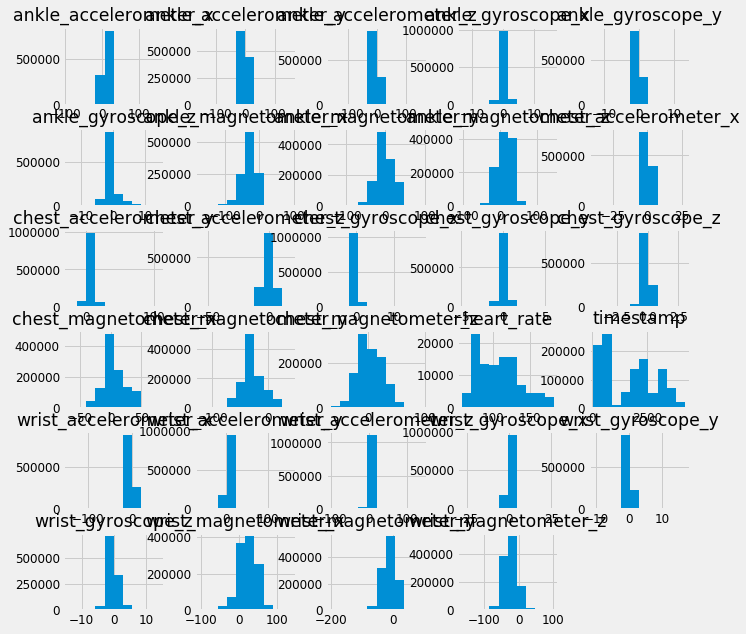

In [13]:
plt.figure(figsize=(13,5))
df_.hist()

In [14]:
#  activity_id count  with origin data 
df.activity_id.value_counts()

walking              207228
lying                168358
standing             164771
sitting              162265
cycling              139125
ascending_stairs     105533
descending_stairs     95289
running               81667
rope_jumping          34163
Name: activity_id, dtype: int64

In [15]:
#  activity_id count with filter data (non-null in observation except heart rate )
df_.activity_id.value_counts()

walking              199366
lying                168131
standing             163915
sitting              161747
cycling              138072
ascending_stairs     105415
descending_stairs     95214
running               79447
rope_jumping          32726
Name: activity_id, dtype: int64

In [16]:
# pivot table on user VS acivity count 

df_user_acivity_count = df_.groupby(['user_id','activity_id']).count()['wrist_accelerometer_x'].reset_index()
pd.pivot_table(df_user_acivity_count, index='user_id',columns='activity_id').reset_index().fillna(0).set_index('user_id')



wrist_accelerometer_x                                      \
activity_id      ascending_stairs  cycling descending_stairs    lying   
user_id                                                                 
a                         15875.0  23492.0           14892.0  27179.0   
b                         17334.0  24595.0           15190.0  23272.0   
c                         10366.0      0.0           15268.0  22041.0   
d                         16683.0  22609.0           14279.0  23029.0   
e                         14250.0  24361.0           12715.0  23670.0   
f                         13285.0  20432.0           11258.0  23330.0   
g                         17622.0  22583.0           11612.0  25610.0   

                                                              
activity_id rope_jumping  running  sitting standing  walking  
user_id                                                       
a                12224.0  20684.0  23465.0  21593.0  21383.0  
b                12801.0   8775.0  22322.0  25416.0  31500.0  
c                    0.0      0.0  28738.0  20408.0  28293.0  
d                    0.0      1.0  25478.0  24651.0  30030.0  
e                 7448.0  24301.0  26720.0  22071.0  30553.0  
f                  253.0  22191.0  22808.0  24064.0  25356.0  
g                    0.0   3495.0  12216.0  25712.0  32251.0

### 1-2) Sequence

In [17]:
#df.iloc[:,3:]

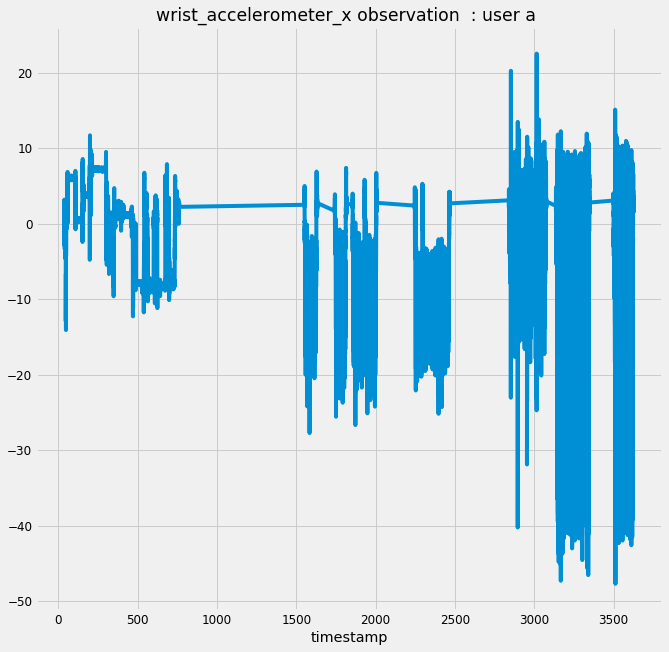

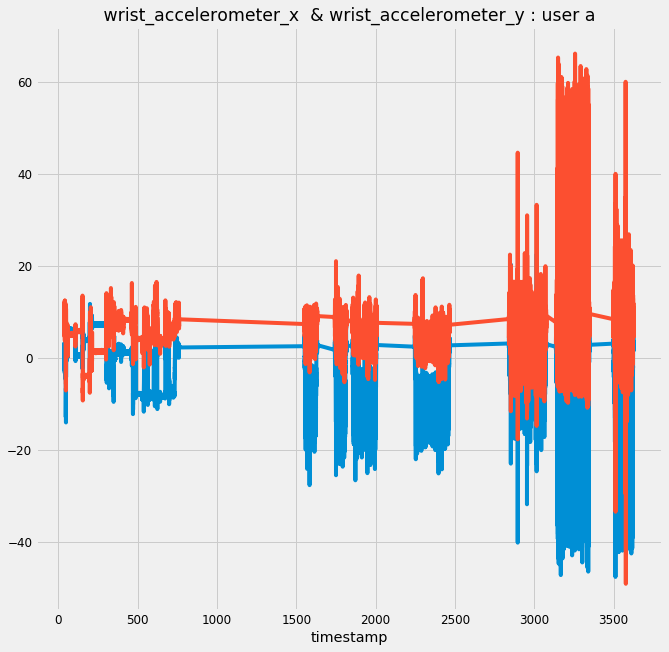

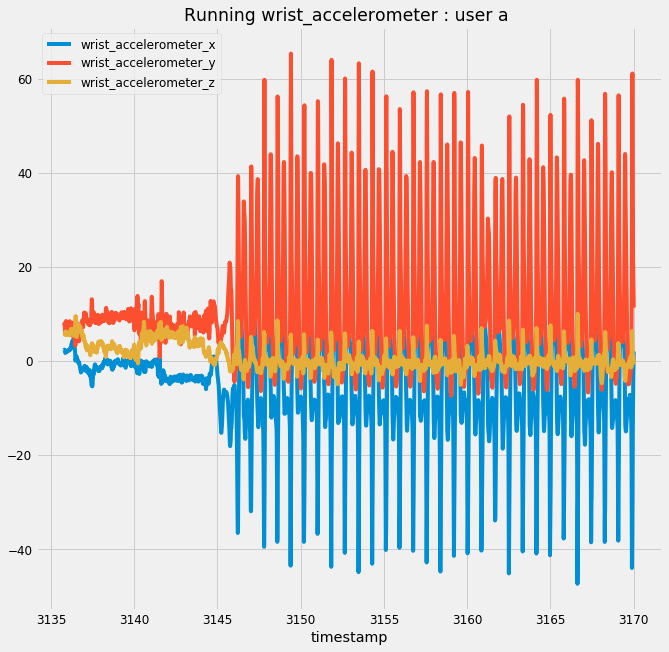

In [18]:
# user a with wrist_accelerometer

#  -------- fig 1 : wrist_accelerometer with User a  -------- # 
df_[(df_.user_id=='a') ]\
  .set_index('timestamp')\
  .wrist_accelerometer_x.plot() 
plt.title('wrist_accelerometer_x observation  : user a ')
plt.show()


#  -------- fig 2 : wrist_accelerometer with User a  -------- # 
df_[(df_.user_id=='a') ]\
  .set_index('timestamp')\
  .wrist_accelerometer_x.plot() 

df_[(df_.user_id=='a') ]\
  .set_index('timestamp')\
  .wrist_accelerometer_y.plot() 

plt.title(' wrist_accelerometer_x  & wrist_accelerometer_y : user a ')
plt.show()


  
# -------- fig 3  : wrist_accelerometer with User a when running  -------- # 
df_[(df_.user_id=='a') & (df_.activity_id=='running') &  (df_.timestamp <= 3170) ]\
  .set_index('timestamp')\
  .wrist_accelerometer_x.plot() 


df_[(df_.user_id=='a') & (df_.activity_id=='running') &  (df_.timestamp <= 3170) ]\
  .set_index('timestamp')\
  .wrist_accelerometer_y.plot() 



df_[(df_.user_id=='a') & (df_.activity_id=='running') &  (df_.timestamp <= 3170) ]\
  .set_index('timestamp')\
  .wrist_accelerometer_z.plot() 

plt.legend(['wrist_accelerometer_x','wrist_accelerometer_y','wrist_accelerometer_z'])
plt.title('Running wrist_accelerometer : user a ')
plt.show()

activity =  rope_jumping


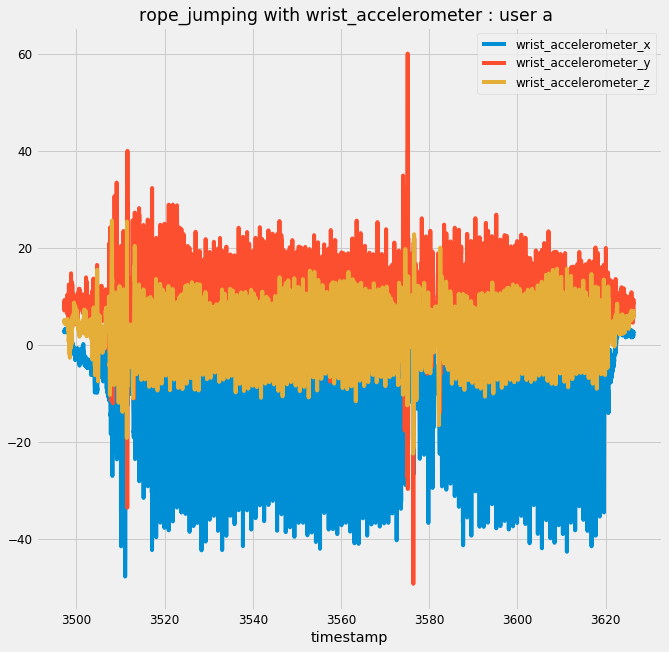

----------
activity =  cycling


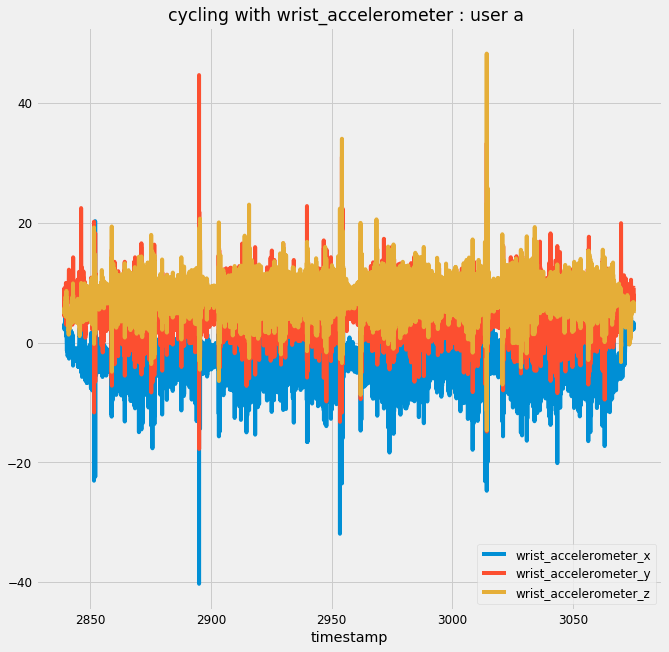

----------
activity =  lying


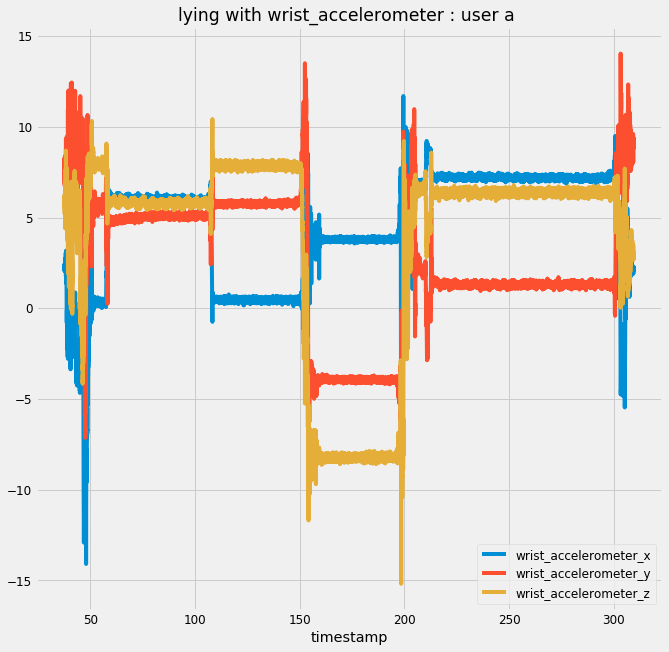

----------
activity =  ascending_stairs


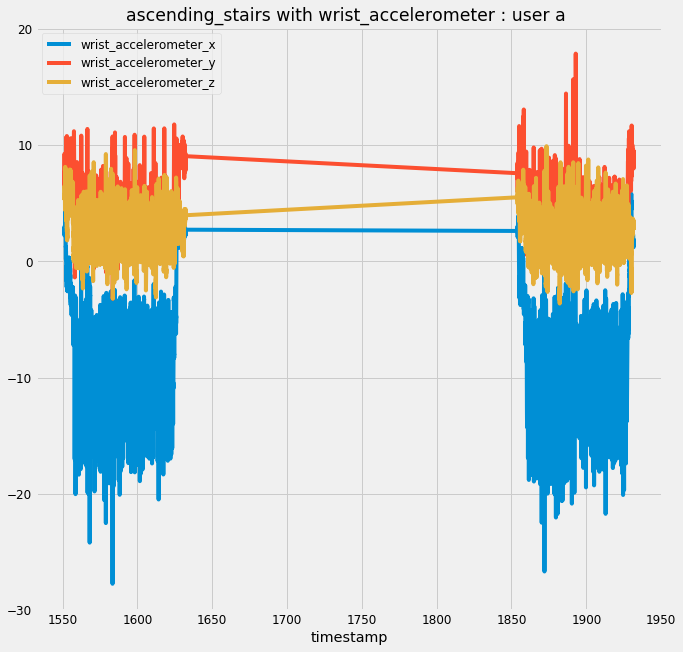

----------
activity =  descending_stairs


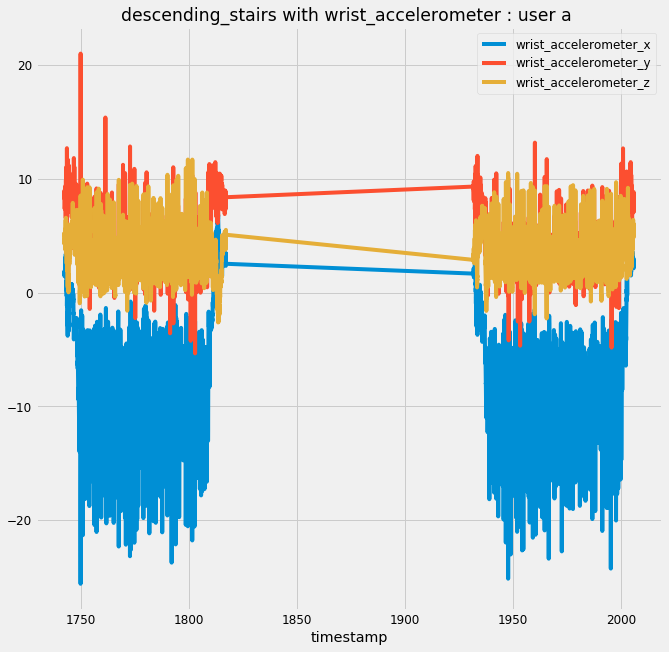

----------
activity =  walking


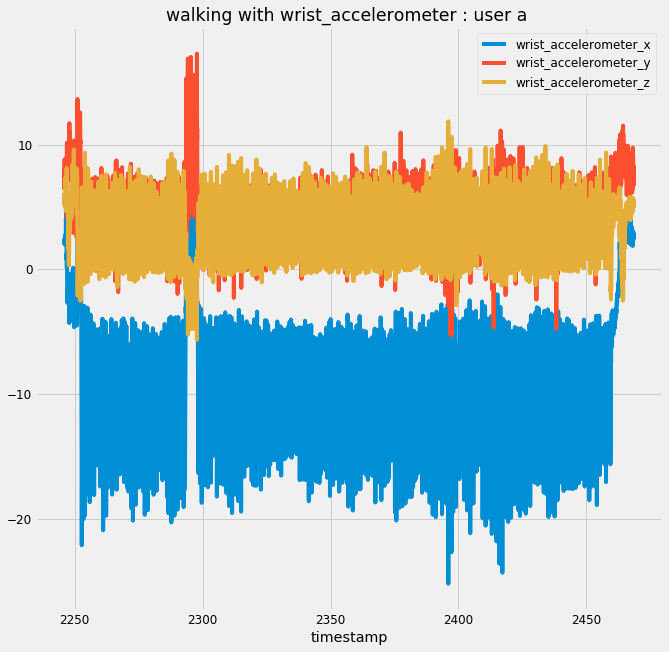

----------
activity =  standing


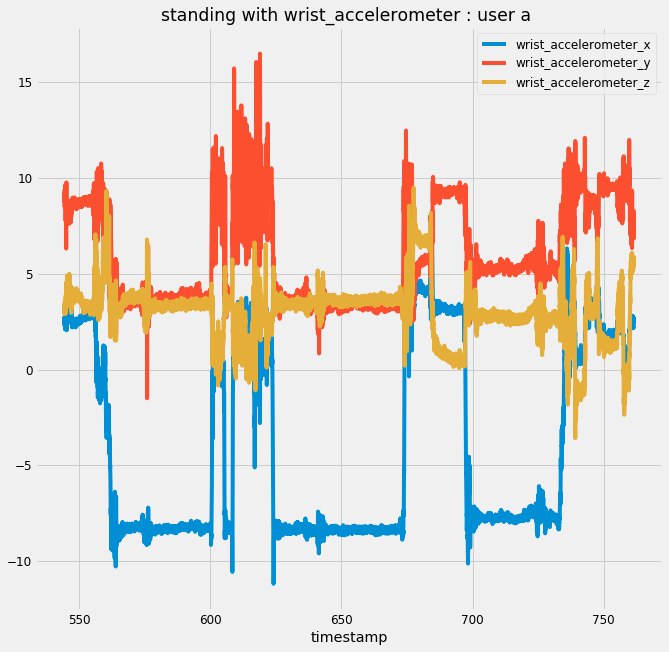

----------
activity =  sitting


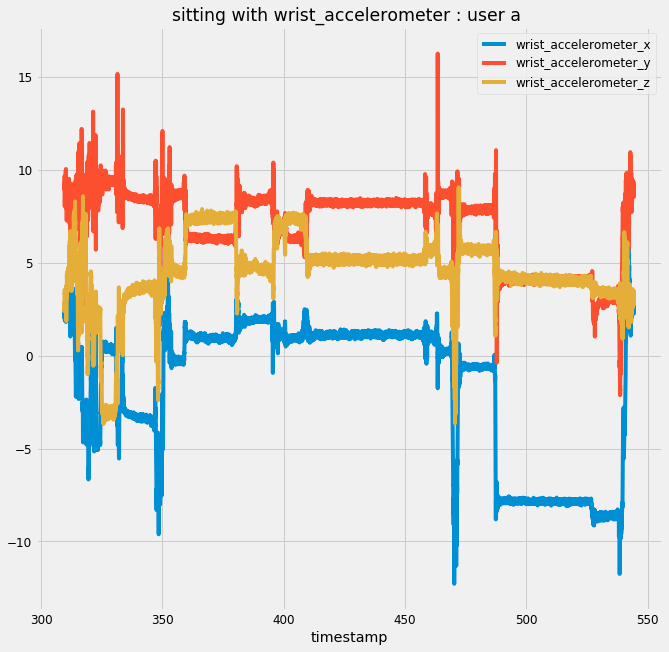

----------
activity =  running


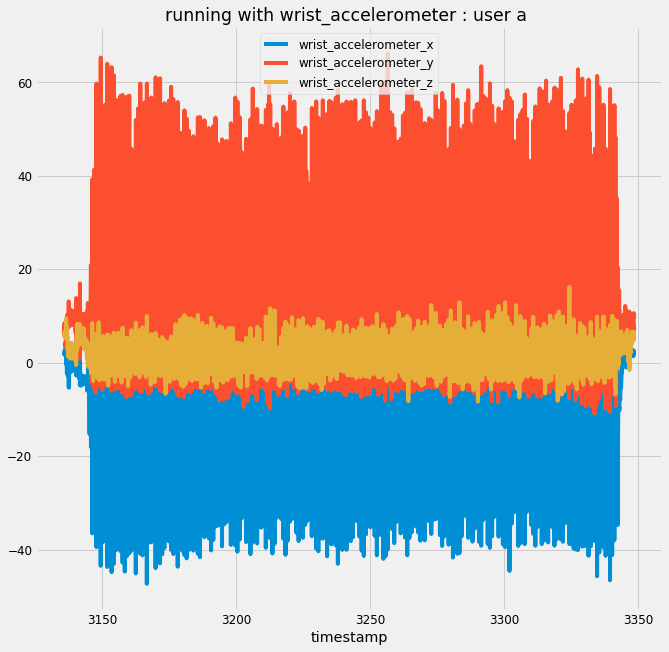

----------


In [19]:
# user a with all activity & wrist_accelerometer_x_y_z 


  
# -------- fig 3  :   -------- # 

user = 'a'
for act in list(set(df_.activity_id)):
    print ('activity = ', act)
    df_[(df_.user_id==user) & (df_.activity_id==act)  ]\
      .set_index('timestamp')\
      .wrist_accelerometer_x.plot() 


    df_[(df_.user_id==user) & (df_.activity_id==act) ]\
      .set_index('timestamp')\
      .wrist_accelerometer_y.plot() 



    df_[(df_.user_id==user) & (df_.activity_id==act)  ]\
      .set_index('timestamp')\
      .wrist_accelerometer_z.plot() 

    plt.legend(['wrist_accelerometer_x','wrist_accelerometer_y','wrist_accelerometer_z'])
    plt.title('{} with wrist_accelerometer : user {} '.format(act,user) )
    plt.show()
    print ('-'*10)

activity =  rope_jumping


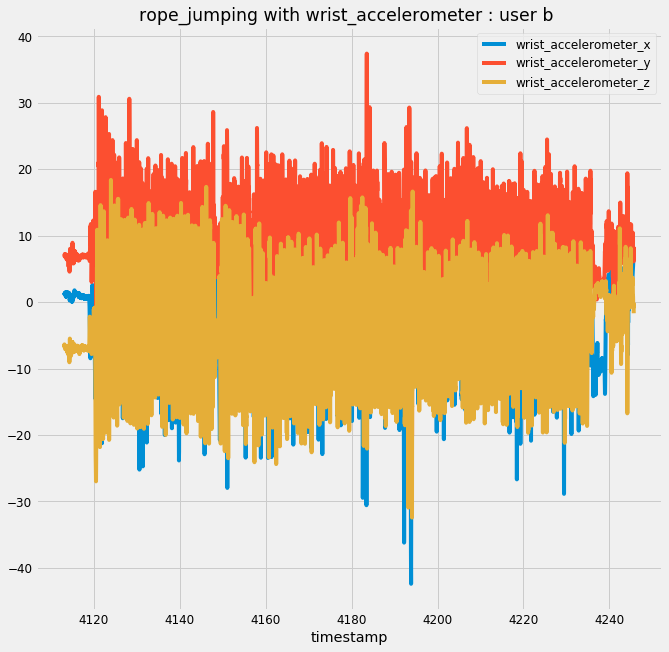

----------
activity =  cycling


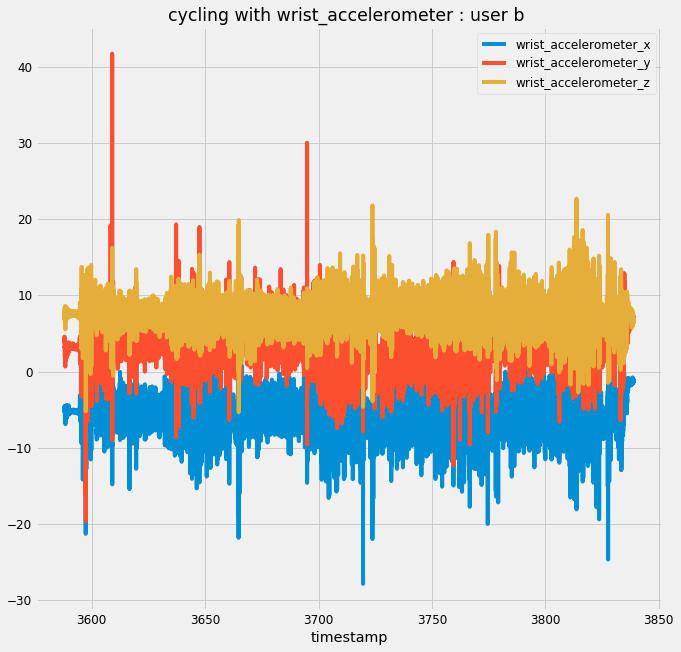

----------
activity =  lying


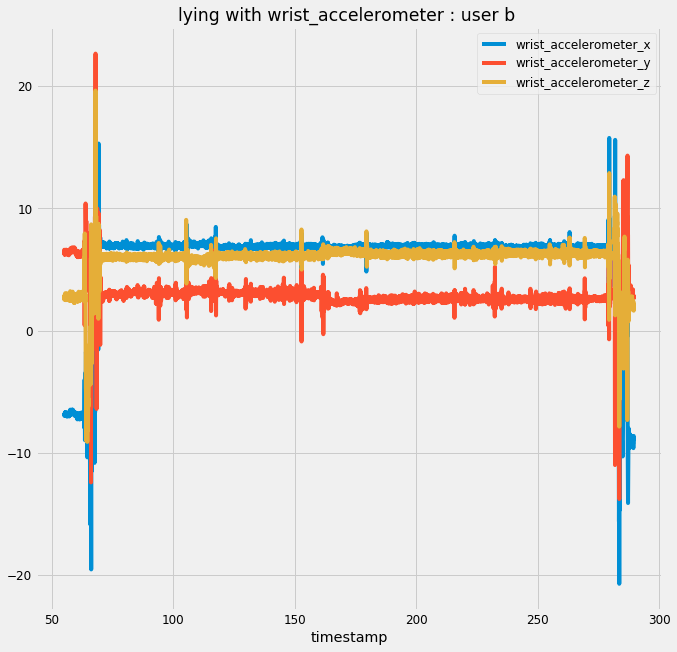

----------
activity =  ascending_stairs


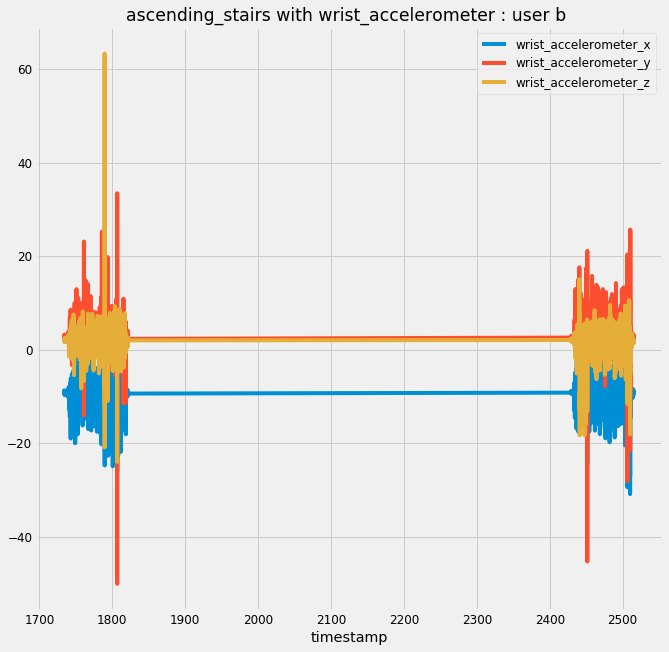

----------
activity =  descending_stairs


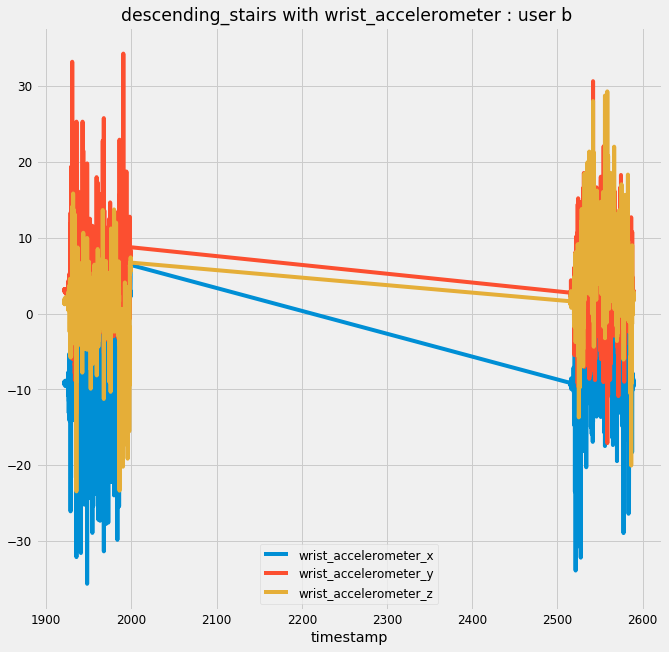

----------
activity =  walking


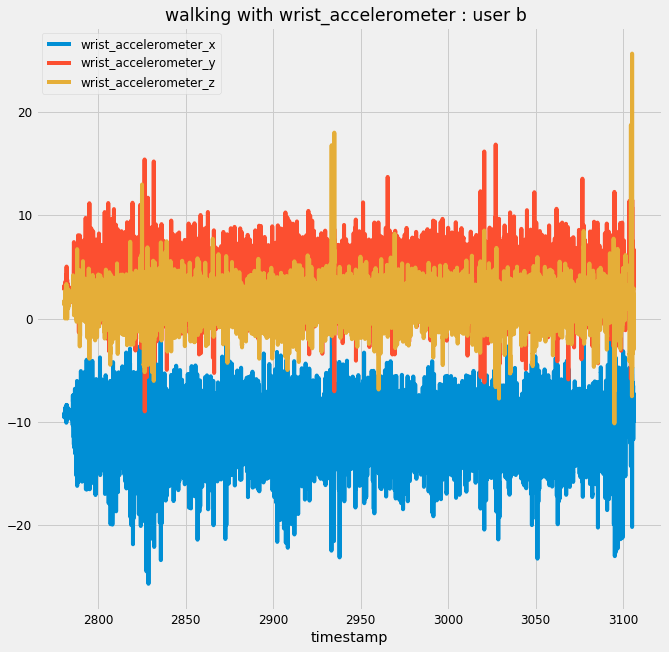

----------
activity =  standing


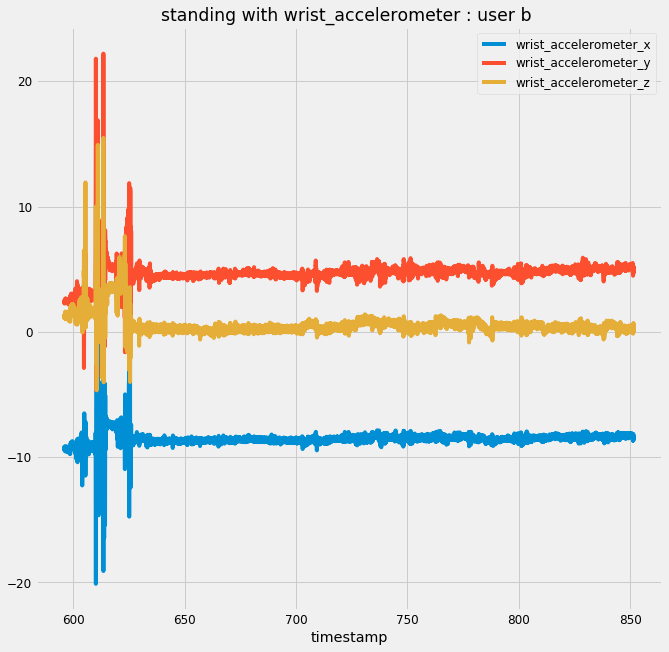

----------
activity =  sitting


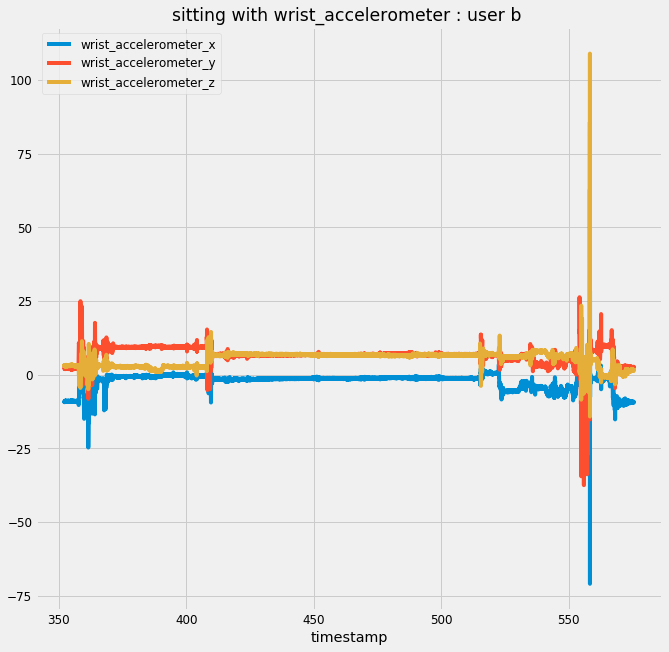

----------
activity =  running


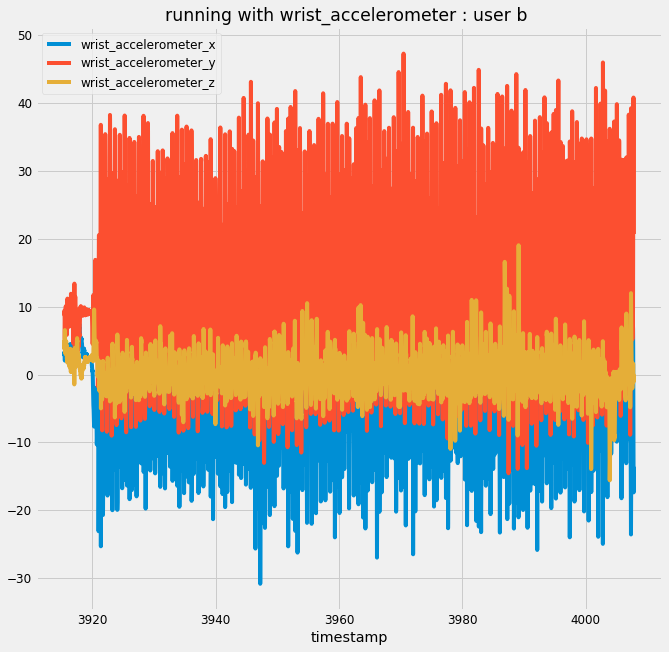

----------


In [20]:
# user b with all activity & wrist_accelerometer_x_y_z 


  
# -------- fig 3  :   -------- # 

user = 'b'
for act in list(set(df_.activity_id)):
    print ('activity = ', act)
    df_[(df_.user_id==user) & (df_.activity_id==act)  ]\
      .set_index('timestamp')\
      .wrist_accelerometer_x.plot() 


    df_[(df_.user_id==user) & (df_.activity_id==act) ]\
      .set_index('timestamp')\
      .wrist_accelerometer_y.plot() 



    df_[(df_.user_id==user) & (df_.activity_id==act)  ]\
      .set_index('timestamp')\
      .wrist_accelerometer_z.plot() 

    plt.legend(['wrist_accelerometer_x','wrist_accelerometer_y','wrist_accelerometer_z'])
    plt.title('{} with wrist_accelerometer : user {} '.format(act,user) )
    plt.show()
    print ('-'*10)

activity =  rope_jumping


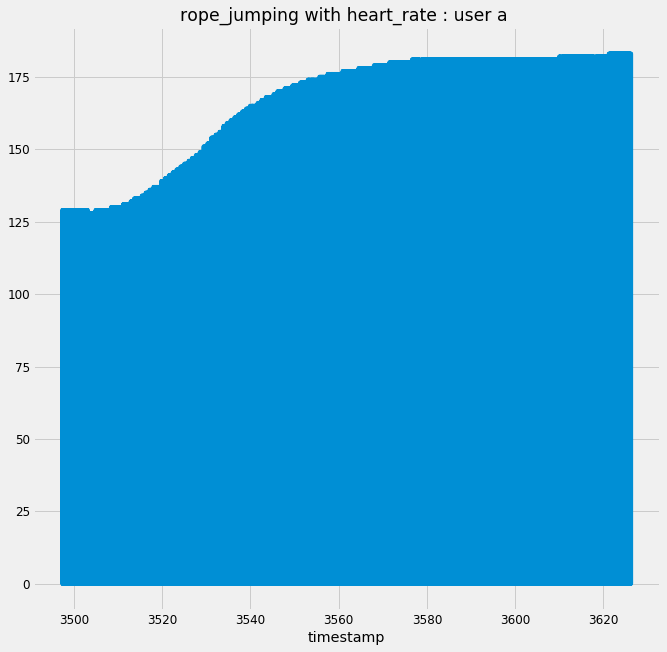

----------
activity =  cycling


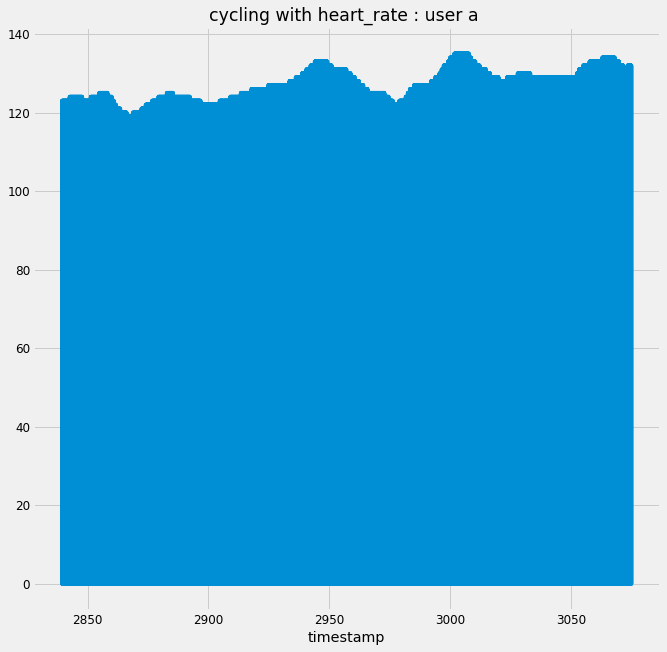

----------
activity =  lying


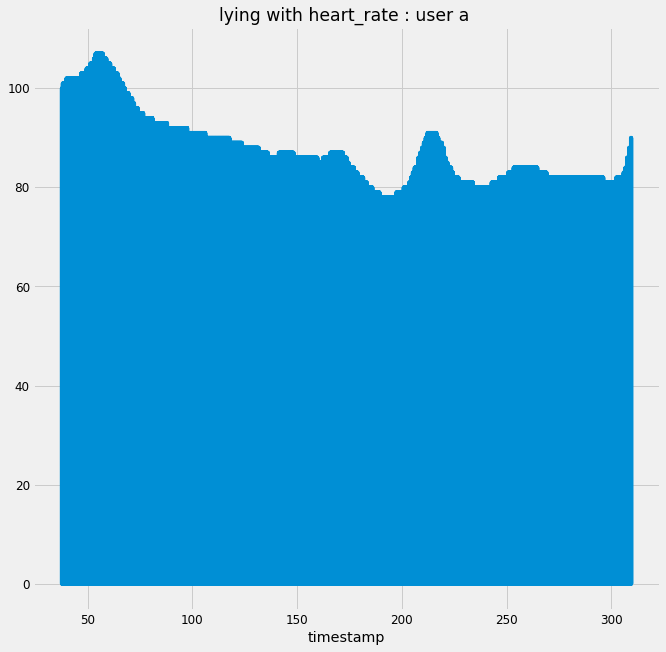

----------
activity =  ascending_stairs


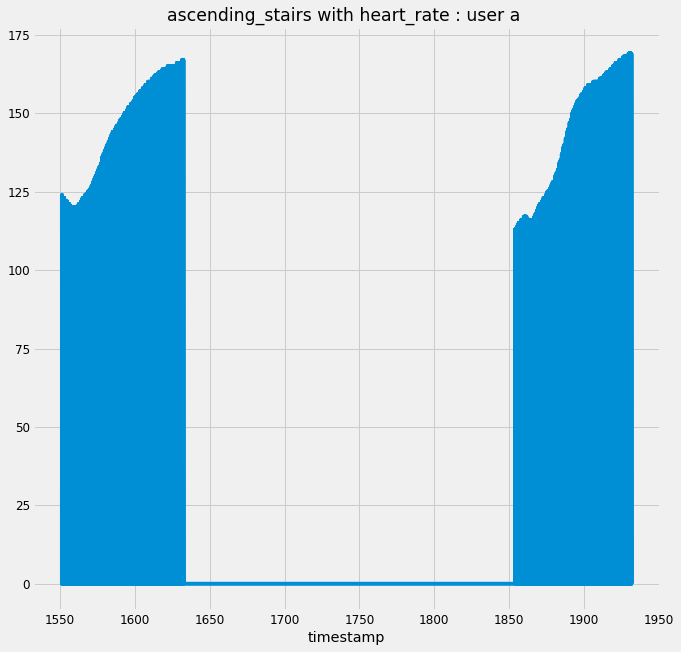

----------
activity =  descending_stairs


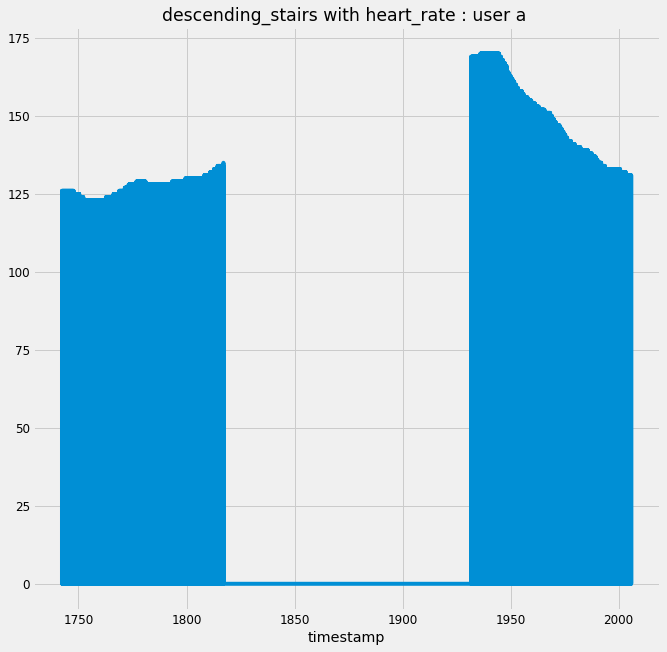

----------
activity =  walking


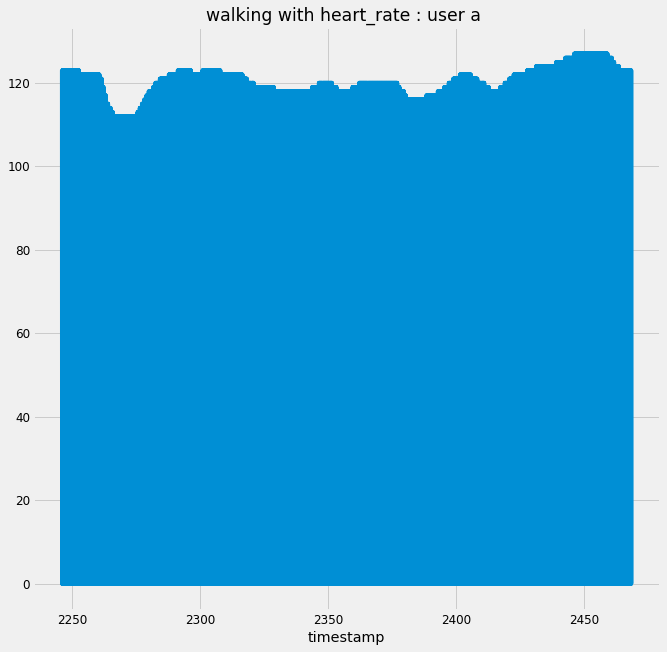

----------
activity =  standing


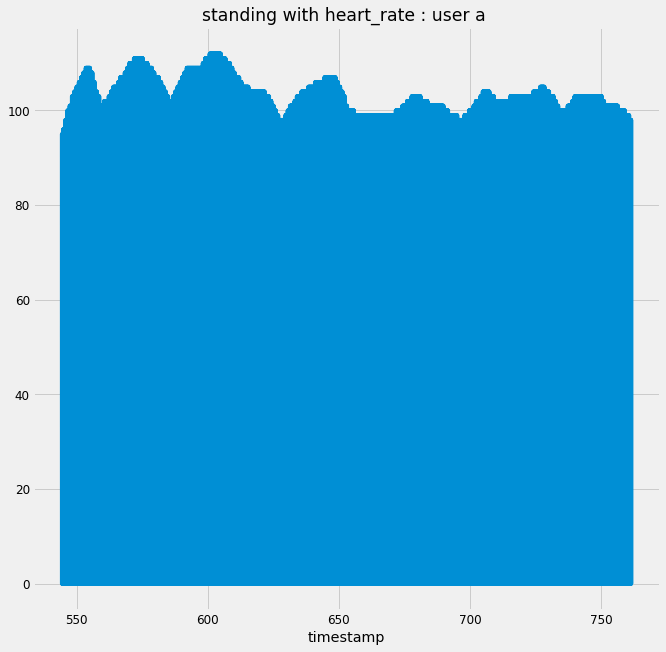

----------
activity =  sitting


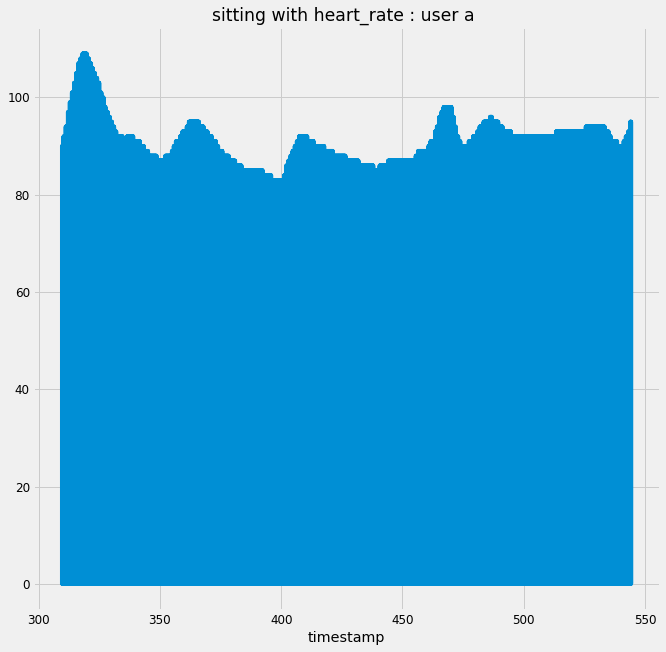

----------
activity =  running


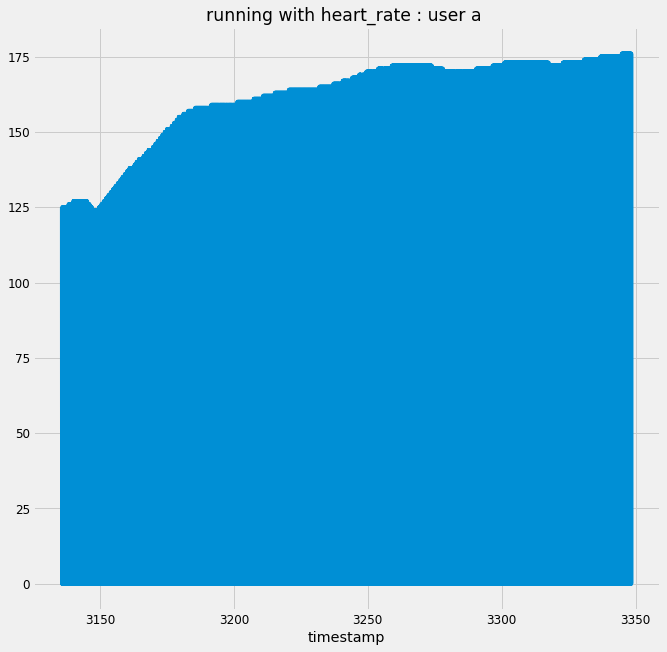

----------


In [21]:
# user b with all activity & heart_rate 


  
# -------- fig 3  :   -------- # 

user = 'a'
for act in list(set(df_.activity_id)):
    print ('activity = ', act)
    df_[(df_.user_id==user) & (df_.activity_id==act)  ]\
      .set_index('timestamp')\
      .heart_rate.fillna(0).plot() 



   # plt.legend(['heart_rate','wrist_accelerometer_y','wrist_accelerometer_z'])
    plt.title('{} with heart_rate : user {} '.format(act,user) )
    plt.show()
    print ('-'*10)

## 2) Feature extract

### 2-1) Time Domain :  mean / median / max / min / variance /

In [55]:
columns=['heart_rate', 'wrist_accelerometer_x',
'wrist_accelerometer_y', 'wrist_accelerometer_z', 'wrist_gyroscope_x',
'wrist_gyroscope_y', 'wrist_gyroscope_z', 'wrist_magnetometer_x',
'wrist_magnetometer_y', 'wrist_magnetometer_z', 'chest_accelerometer_x',
'chest_accelerometer_y', 'chest_accelerometer_z', 'chest_gyroscope_x',
'chest_gyroscope_y', 'chest_gyroscope_z', 'chest_magnetometer_x',
'chest_magnetometer_y', 'chest_magnetometer_z', 'ankle_accelerometer_x',
'ankle_accelerometer_y', 'ankle_accelerometer_z', 'ankle_gyroscope_x',
'ankle_gyroscope_y', 'ankle_gyroscope_z', 'ankle_magnetometer_x',
'ankle_magnetometer_y', 'ankle_magnetometer_z']




def get_x_y_z_sum_squre_aggregration(x,y,z):
	#print ( np.sqrt(x**2 + y**2 + z**2))
	return np.sqrt(x**2 + y**2 + z**2)



def get_x_y_z_abs_sum_aggregration(x,y,z):
	#print ( np.sqrt(x**2 + y**2 + z**2))
	return (abs(x) + abs(y)+ abs(z))


def get_direction_cosines(x,y,z):
	# http://www.geom.uiuc.edu/docs/reference/CRC-formulas/node52.html
	x_y_z_length =  np.sqrt(x**2 + y**2 + z**2)
	cos_alpha = x/x_y_z_length
	cos_beta = y/x_y_z_length
	cos_gamma = z/x_y_z_length
	return [cos_alpha, cos_beta,cos_gamma ]




def get_avg_values_(df):
	df_avg = df.groupby('activity_id').mean()
	# neglect timestamp 
	for col in columns:
		# 'wrist_accelerometer_x','wrist_accelerometer_y',...
		print ('col : ' , col)
		df_avg_ = df_avg[col].reset_index()
		df_avg_.columns = ['activity_id','avg_{}'.format(col)]
		# merge back 
		df = pd.merge(df,df_avg_,on = 'activity_id')
	return df



def get_std_values_(df):
	df_std = df.groupby('activity_id').std()
	# neglect timestamp 
	for col in columns:
		# 'wrist_accelerometer_x','wrist_accelerometer_y',...
		print ('col : ' , col)
		df_std_ = df_std[col].reset_index()
		df_std_.columns = ['activity_id','std_{}'.format(col)]
		# merge back 
		df = pd.merge(df,df_std_,on = 'activity_id')
	return df



def get_median_values_(df):
	df_median = df.groupby('activity_id').median()
	# neglect timestamp 
	for col in columns:
		# 'wrist_accelerometer_x','wrist_accelerometer_y',...
		print ('col : ' , col)
		df_median_ = df_median[col].reset_index()
		df_median_.columns = ['activity_id','median_{}'.format(col)]
		# merge back 
		df = pd.merge(df,df_median_,on = 'activity_id')
	return df


def get_max_values_(df):
	df_max = df.groupby('activity_id').max()
	# neglect timestamp 
	for col in columns:
		# 'wrist_accelerometer_x','wrist_accelerometer_y',...
		print ('col : ' , col)
		df_max_ = df_max[col].reset_index()
		df_max_.columns = ['activity_id','max_{}'.format(col)]
		# merge back 
		df = pd.merge(df,df_max_,on = 'activity_id')
	return df



def get_min_values_(df):
	df_min = df.groupby('activity_id').min()
	# neglect timestamp 
	for col in columns:
		# 'wrist_accelerometer_x','wrist_accelerometer_y',...
		print ('col : ' , col)
		df_min_ = df_min[col].reset_index()
		df_min_.columns = ['activity_id','min_{}'.format(col)]
		# merge back 
		df = pd.merge(df,df_min_,on = 'activity_id')
	return df


In [23]:
# get statistics feature 

df_feature = get_avg_values_(df_)
df_feature = get_std_values_(df_feature)
df_feature = get_median_values_(df_feature)
df_feature = get_max_values_(df_feature)
df_feature = get_min_values_(df_feature)

col :  heart_rate
col :  wrist_accelerometer_x
col :  wrist_accelerometer_y
col :  wrist_accelerometer_z
col :  wrist_gyroscope_x
col :  wrist_gyroscope_y
col :  wrist_gyroscope_z
col :  wrist_magnetometer_x
col :  wrist_magnetometer_y
col :  wrist_magnetometer_z
col :  chest_accelerometer_x
col :  chest_accelerometer_y
col :  chest_accelerometer_z
col :  chest_gyroscope_x
col :  chest_gyroscope_y
col :  chest_gyroscope_z
col :  chest_magnetometer_x
col :  chest_magnetometer_y
col :  chest_magnetometer_z
col :  ankle_accelerometer_x
col :  ankle_accelerometer_y
col :  ankle_accelerometer_z
col :  ankle_gyroscope_x
col :  ankle_gyroscope_y
col :  ankle_gyroscope_z
col :  ankle_magnetometer_x
col :  ankle_magnetometer_y
col :  ankle_magnetometer_z
col :  heart_rate
col :  wrist_accelerometer_x
col :  wrist_accelerometer_y
col :  wrist_accelerometer_z
col :  wrist_gyroscope_x
col :  wrist_gyroscope_y
col :  wrist_gyroscope_z
col :  wrist_magnetometer_x
col :  wrist_magnetometer_y
col :  w

In [79]:
# get space features 

# V1 
#df_['wrist_accelerometer_sum_squre'] = df_.apply(lambda row : pd.Series(get_x_y_z_sum_squre_aggregration(
#row['wrist_accelerometer_x'],
#row['wrist_accelerometer_y'],
#row['wrist_accelerometer_z'])),axis=1)

#df_['wrist_accelerometer_abs_sum'] =  df_.apply(lambda row : pd.Series(get_x_y_z_abs_sum_aggregration(
#row['wrist_accelerometer_x'],
#row['wrist_accelerometer_y'],
#row['wrist_accelerometer_z'])),axis=1)

# V2 
# sum_squre
df_feature['wrist_accelerometer_sum_squre']  =  np.sqrt(df_feature['wrist_accelerometer_x']**2 + df_feature['wrist_accelerometer_y']**2 + df_feature['wrist_accelerometer_z']**2)
# abs sum 
df_feature['wrist_accelerometer_abs_sum']  = abs(df_feature['wrist_accelerometer_x']) + abs(df_feature['wrist_accelerometer_y'])  + abs(df_feature['wrist_accelerometer_z']) 
# direction_cosines
x_y_z_length = np.sqrt(df_feature['wrist_accelerometer_x']**2 + df_feature['wrist_accelerometer_y']**2 + df_feature['wrist_accelerometer_z']**2)
df_feature['wrist_accelerometer_cos_alpha'] = df_feature['wrist_accelerometer_x']/x_y_z_length



In [25]:
#plt.figure(figsize=(30, 20))

#sns.lmplot( x="wrist_accelerometer_z", y="avg_chest_magnetometer_z", data=df_zz, fit_reg=False, hue='activity_id', legend=False)
 
# Move the legend to an empty part of the plot
#plt.legend(loc='lower outside')



In [26]:
#plt.figure(figsize=(30, 20))
#sns.lmplot( x="wrist_accelerometer_y", y="avg_ankle_magnetometer_z", data=df_zz, fit_reg=False, hue='activity_id', legend=False)
 
# Move the legend to an empty part of the plot
#plt.legend(loc='lower outside')



### 2-2) Frequence Domain

### 2-2) PCA

In [108]:
#X= df_feature.iloc[:,3:]
#X= df_feature.iloc[:,-10:]
# it's cost too much resources if train all 100+ cols with PCA model
# so here I just slightly merge original cols and extract feature cols and run PCA as a test 
X= pd.merge(df_feature.iloc[:,-10:],df_feature.iloc[:,3:5],left_index=True,right_index=True)
y= df_feature['activity_id']

In [109]:
# PCA -> to 3 Principal component
pca = PCA(n_components=3)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [110]:
# evaluate PCA explained performance
print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

[ 0.62126111  0.27117211  0.04279175]
[ 55776.68421038  36850.0535918   14638.46838982]


In [111]:
X_pca = pca.fit_transform(X)

In [112]:
X_pca

array([[ -37.23540545,  -10.82814141,  -10.27255606],
       [ -37.27797341,  -10.83056501,  -10.38998521],
       [ -37.31886301,  -10.83338702,  -10.49839512],
       ..., 
       [  17.42667524,  101.47467692,  -14.55788331],
       [  17.40613863,  101.47463875,  -14.59229831],
       [  17.3999652 ,  101.47443125,  -14.60079818]])

In [113]:
df_xpca= pd.DataFrame(X_pca)
df_xpca_ = pd.merge(df_xpca,pd.DataFrame(y),left_index=True,right_index=True)
df_xpca_.head(3)

,0,1,2,activity_id
0,-37.235405,-10.828141,-10.272556,lying
1,-37.277973,-10.830565,-10.389985,lying
2,-37.318863,-10.833387,-10.498395,lying


In [115]:
df_xpca_

,0,1,2,activity_id
0,-37.235405,-10.828141,-10.272556,lying
1,-37.277973,-10.830565,-10.389985,lying
2,-37.318863,-10.833387,-10.498395,lying
3,-37.314107,-10.834137,-10.492799,lying
4,-37.290592,-10.832907,-10.448696,lying
5,-37.297319,-10.835026,-10.460389,lying
6,-37.270816,-10.829955,-10.386559,lying
7,-37.283620,-10.830393,-10.400998,lying
8,-37.276008,-10.830304,-10.376395,lying
9,-37.289568,-10.832806,-10.422554,lying


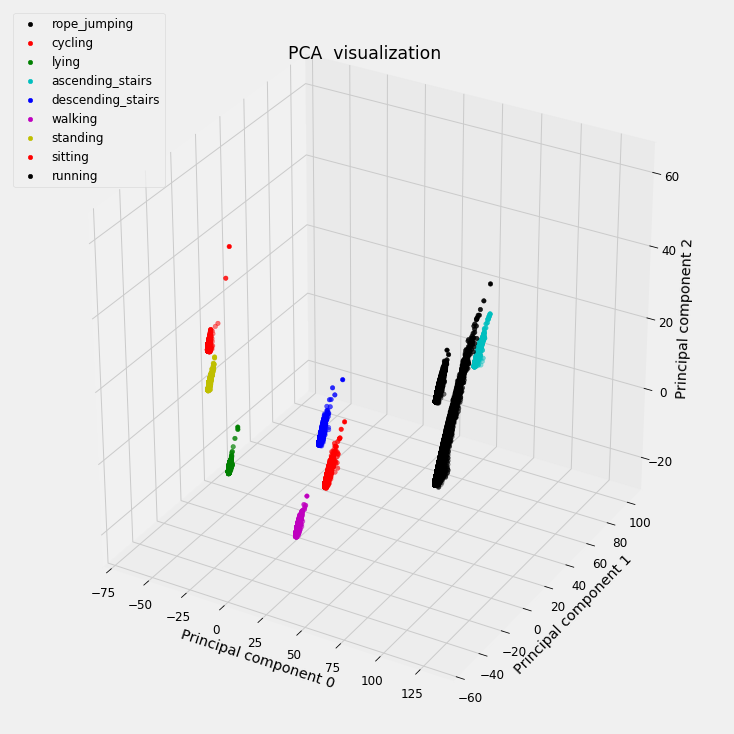

In [114]:
# 3D plot
colorlist = ['k', 'red', 'g', 'c', 'b', 'm', 'y', 'r']

fig = pyplot.figure()
ax = Axes3D(fig)
for k, group in enumerate(set(df_xpca_.activity_id)):
    ax.scatter(df_xpca_[df_xpca_.activity_id == group][0],
               df_xpca_[df_xpca_.activity_id == group ][1],
               df_xpca_[df_xpca_.activity_id == group ][2],
               label = group,
               color=colorlist[k %len(colorlist)])

#ax.scatter(df_train.Frequency, df_train.LTV, df_train.period_no_use,c=df_train.group)
plt.legend(loc='upper left')
ax.set_xlabel('Principal component 0 ')
ax.set_ylabel('Principal component 1 ')
ax.set_zlabel('Principal component 2 ')
plt.title('PCA  visualization ')
pyplot.show()

## 3) Model

### 3-0) Train-Test Split 

In [34]:
df_feature.head(3)

,timestamp,activity_id,heart_rate,wrist_accelerometer_x,wrist_accelerometer_y,wrist_accelerometer_z,wrist_gyroscope_x,wrist_gyroscope_y,wrist_gyroscope_z,wrist_magnetometer_x,...,min_chest_magnetometer_z,min_ankle_accelerometer_x,min_ankle_accelerometer_y,min_ankle_accelerometer_z,min_ankle_gyroscope_x,min_ankle_gyroscope_y,min_ankle_gyroscope_z,min_ankle_magnetometer_x,min_ankle_magnetometer_y,min_ankle_magnetometer_z
0,37.66,lying,NaN,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,8.93200,...,-66.6847,-9.74983,-73.7981,-28.3876,-7.21181,-2.32679,-3.82356,-126.418,-82.5699,-61.1634
1,37.67,lying,NaN,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,9.58300,...,-66.6847,-9.74983,-73.7981,-28.3876,-7.21181,-2.32679,-3.82356,-126.418,-82.5699,-61.1634
2,37.68,lying,NaN,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,9.05516,...,-66.6847,-9.74983,-73.7981,-28.3876,-7.21181,-2.32679,-3.82356,-126.418,-82.5699,-61.1634


In [118]:
df_xpca_.head(3)

,0,1,2,activity_id
0,-37.235405,-10.828141,-10.272556,lying
1,-37.277973,-10.830565,-10.389985,lying
2,-37.318863,-10.833387,-10.498395,lying


In [122]:
X = df_xpca_[[0,1,2]]
y = df_xpca_['activity_id']

In [123]:
#  train - test split via StratifiedShuffleSplit
#  to keep the pct on every group. i.e. keep the pct on lying,running.. over all data count
#  http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit
#  split train,test with 0.8, 0.2 pct



from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
sss.get_n_splits(X, y)
StratifiedShuffleSplit(n_splits=3, random_state=17)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    



TRAIN: [ 354562  969482 1070083 ...,  842815  902605  406570] TEST: [ 47931 420761 731649 ..., 574429 652884 223326]
TRAIN: [149682 633149 106181 ..., 510269 279543 208279] TEST: [ 900626  532958 1074389 ...,  590557  229680  898473]
TRAIN: [136266  90483 656101 ..., 792626 263569  55504] TEST: [256148 474373 419665 ..., 566558 276389 427320]


In [124]:
# check train, test count 
print ('len of X_train : ', len(X_train))
print ('len of y_train : ', len(y_train))
print ('len of X_test : ', len(X_test))
print ('len of y_test : ', len(y_test))

len of X_train :  800823
len of y_train :  800823
len of X_test :  343210
len of y_test :  343210


In [125]:
# test group pct

print ('---------- y_train : ----------' )
print  (y_train.value_counts()/len(y_train))

print ('---------- original data  : ----------' )
print (df_feature.activity_id.value_counts()/len(df_feature))

---------- y_train : ----------
walking              0.174266
lying                0.146964
standing             0.143278
sitting              0.141383
cycling              0.120688
ascending_stairs     0.092144
descending_stairs    0.083227
running              0.069445
rope_jumping         0.028606
Name: activity_id, dtype: float64
---------- original data  : ----------
walking              0.174266
lying                0.146963
standing             0.143278
sitting              0.141383
cycling              0.120689
ascending_stairs     0.092143
descending_stairs    0.083227
running              0.069445
rope_jumping         0.028606
Name: activity_id, dtype: float64


### 3-1) SVM Model

In [126]:

#X= df_feature.iloc[:,3:10]
#y= df_feature['activity_id']

In [127]:
"""
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
sss.get_n_splits(X, y)
StratifiedShuffleSplit(n_splits=3, random_state=17)
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
    y_train, y_test = y[train_index], y[test_index]
""" 

'\nfrom sklearn.model_selection import StratifiedShuffleSplit\nsss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)\nsss.get_n_splits(X, y)\nStratifiedShuffleSplit(n_splits=3, random_state=17)\nfor train_index, test_index in sss.split(X, y):\n    print("TRAIN:", train_index, "TEST:", test_index)\n    X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]\n    y_train, y_test = y[train_index], y[test_index]\n'

In [40]:
# check train, test count 
print ('len of X_train : ', len(X_train))
print ('len of y_train : ', len(y_train))
print ('len of X_test : ', len(X_test))
print ('len of y_test : ', len(y_test))

len of X_train :  800823
len of y_train :  800823
len of X_test :  343210
len of y_test :  343210


In [128]:
from sklearn.svm import SVC

In [129]:
# use linear kernel for fast initial train 
clf = SVC(kernel='linear')
clf.fit( X_train[:1000], y_train.head(1000)) 
#clf.fit( X_train, y_train) 
# X_train, X_test   y_train, y_test 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [142]:
list(set(pd.DataFrame(y_train)['activity_id']))

['rope_jumping',
 'cycling',
 'lying',
 'ascending_stairs',
 'descending_stairs',
 'walking',
 'standing',
 'sitting',
 'running']

In [130]:
pred = clf.predict(X_test)

In [131]:
clf.score(X_test,y_test)

0.99999417266396662


Precision: 99.99941730719577%
Recall: 99.99941726639666%
f1_score: 99.99941726956251%

Confusion Matrix:
[[31624     0     0     0     0     0     0     0     0]
 [    0 41420     2     0     0     0     0     0     0]
 [    0     0 28564     0     0     0     0     0     0]
 [    0     0     0 50439     0     0     0     0     0]
 [    0     0     0     0  9818     0     0     0     0]
 [    0     0     0     0     0 23834     0     0     0]
 [    0     0     0     0     0     0 48524     0     0]
 [    0     0     0     0     0     0     0 49175     0]
 [    0     0     0     0     0     0     0     0 59810]]

Confusion matrix (normalised to % of total test data):
[[  9.21418374e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  0.00000000e+00   1.20684129e+01   5.82733603e-04   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  

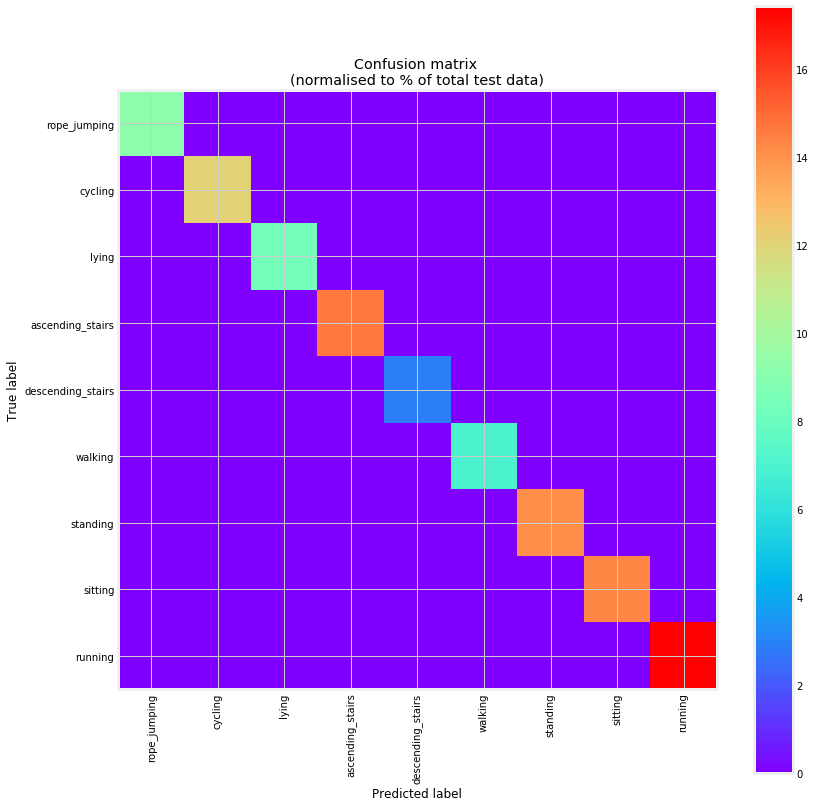

In [146]:
# Results
LABELS = list(set(pd.DataFrame(y_train)['activity_id']))

#print("Testing Accuracy: {}%".format(100*clf.score(X_test,y_test)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [132]:
df_y_test_ = pd.DataFrame(y_test).reset_index()
pd.merge(pd.DataFrame(pred),
         df_y_test_,
         left_index=True,
         right_index=True)

,0,index,activity_id
0,sitting,256148,sitting
1,standing,474373,standing
2,standing,419665,standing
3,walking,710221,walking
4,rope_jumping,1117587,rope_jumping
5,walking,748551,walking
6,walking,874524,walking
7,cycling,920522,cycling
8,cycling,906303,cycling
9,walking,795516,walking
